In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error

In [2]:
model = load_model('model1_waterflow_mse_32.hdf5')

In [3]:
df = pd.read_csv('Sub0-RAW.csv')
df.head()

,Dates,Year,Month,Day,Hours,Precipitation,Temperature,Outflow
0,10/1/1980,1980,10,1,0:00:00,0.0,102.992,5.0
1,10/1/1980,1980,10,1,1:00:00,0.0,97.790,5.0
2,10/1/1980,1980,10,1,2:00:00,0.0,92.588,5.0
3,10/1/1980,1980,10,1,3:00:00,0.0,87.404,5.0
4,10/1/1980,1980,10,1,4:00:00,0.0,85.172,5.0


In [4]:
train_cols = ["Precipitation","Temperature","Outflow"]

In [5]:
new_df = df.filter(train_cols, axis=1)

In [6]:
def lag_seq(df, n_seq):
    for i in range(n_seq):
        df['Outflow(t+%d)' %(i+1)] = new_df['Outflow'].shift(-(i+1))
    return df

In [7]:
lag_df = lag_seq(new_df, 1)
lag_df.dropna(inplace=True)

In [8]:
lag_df

,Precipitation,Temperature,Outflow,Outflow(t+1)
0,0.0,102.992,5.0,5.0
1,0.0,97.790,5.0,5.0
2,0.0,92.588,5.0,5.0
3,0.0,87.404,5.0,5.0
4,0.0,85.172,5.0,5.0
...,...,...,...,...
185538,0.0,52.880,29.0,30.0
185539,0.0,54.284,30.0,29.0
185540,0.0,55.670,29.0,29.0
185541,0.0,57.074,29.0,31.0


In [9]:
#label_cols = ["Outflow(t+1)", "Outflow(t+2)", "Outflow(t+3)"]
label_cols = ["Outflow(t+1)"]

In [10]:
#Min Max scalr normalizing
xtrain_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
ytrain_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
xtest_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
ytest_min_max_scaler = MinMaxScaler(feature_range = (0, 1))

In [11]:
#Splitting training and test data
df_train, df_test = train_test_split(lag_df, train_size=0.8, test_size=0.2, shuffle=False)
x_train = df_train.loc[:,train_cols].values
y_train = df_train.loc[:,label_cols].values
x_test = df_test.loc[:,train_cols].values
y_test = df_test.loc[:,label_cols].values

In [12]:
x_train.shape, y_test.shape

((148434, 3), (37109, 1))

In [13]:
# data preparation for tuning with extreme values
values_above_thres = []
labels_above_thres = []
index_values = []
threshold = 250

for i in range(x_train.shape[0]):
    if (y_train[i] > threshold):
        values_above_thres.append(x_train[i])
        labels_above_thres.append(y_train[i])
        index_values.append(i)

In [14]:
#inserting values that are above threshold
x_train = list(x_train)
y_train = list(y_train)
len_values_above_thres = len(values_above_thres)
new_len = len_values_above_thres + len(x_train)
count = 0
for i in range(len_values_above_thres):
    x_train.insert(index_values[i]+count, values_above_thres[i])
    y_train.insert(index_values[i]+count, labels_above_thres[i])
    count += 1

In [15]:
#checking data after appending the extreme values
index_values

[2843,
 2844,
 2845,
 2846,
 2847,
 2848,
 2849,
 2850,
 2851,
 2852,
 3708,
 3709,
 3710,
 3711,
 3712,
 3713,
 3714,
 3715,
 3716,
 3717,
 3718,
 4068,
 4069,
 4070,
 4071,
 4072,
 4073,
 9795,
 9796,
 9797,
 9798,
 9799,
 9800,
 9801,
 9802,
 9803,
 9804,
 10905,
 10906,
 10907,
 10908,
 10909,
 10910,
 10911,
 10912,
 10913,
 10914,
 10915,
 10916,
 10917,
 11048,
 11049,
 11050,
 11051,
 11052,
 11053,
 11054,
 11055,
 11056,
 11057,
 11058,
 11059,
 11060,
 11061,
 11062,
 11063,
 12049,
 12050,
 12051,
 12052,
 12053,
 12054,
 12055,
 12056,
 12057,
 12058,
 12059,
 12060,
 12061,
 12062,
 12063,
 12064,
 12065,
 12066,
 12067,
 12068,
 12069,
 12070,
 12071,
 12072,
 12073,
 12074,
 12611,
 12612,
 12613,
 12614,
 12615,
 12616,
 12617,
 12618,
 12619,
 12620,
 12621,
 12622,
 12623,
 12754,
 12755,
 12756,
 12757,
 12758,
 12759,
 12760,
 12761,
 12762,
 12763,
 12764,
 12765,
 12766,
 12767,
 12768,
 12769,
 12770,
 12771,
 12776,
 12777,
 12778,
 12779,
 12780,
 12781,
 1278

In [16]:
values_above_thres[0:10]

[array([1.38424478e-01, 4.56080000e+01, 2.28000000e+02]),
 array([1.17188904e-01, 4.60400000e+01, 2.62000000e+02]),
 array([2.7527595e-02, 4.5662000e+01, 2.9000000e+02]),
 array([2.91006e-02, 4.53020e+01, 3.09000e+02]),
 array([2.5168087e-02, 4.4942000e+01, 3.1400000e+02]),
 array([2.2022076e-02, 4.5626000e+01, 3.0900000e+02]),
 array([2.1235573e-02, 4.6328000e+01, 2.9800000e+02]),
 array([3.775213e-02, 4.701200e+01, 2.860000e+02]),
 array([2.7527595e-02, 4.8218000e+01, 2.7500000e+02]),
 array([1.4943552e-02, 4.9424000e+01, 2.6400000e+02])]

In [17]:
lag_df[2842:2854]

,Precipitation,Temperature,Outflow,Outflow(t+1)
2842,0.148649,45.194,195.0,228.0
2843,0.138424,45.608,228.0,262.0
2844,0.117189,46.040,262.0,290.0
2845,0.027528,45.662,290.0,309.0
2846,0.029101,45.302,309.0,314.0
2847,0.025168,44.942,314.0,309.0
2848,0.022022,45.626,309.0,298.0
2849,0.021236,46.328,298.0,286.0
2850,0.037752,47.012,286.0,275.0
2851,0.027528,48.218,275.0,264.0


In [18]:
x_train[2842:2858]

[array([1.48649013e-01, 4.51940000e+01, 1.95000000e+02]),
 array([1.38424478e-01, 4.56080000e+01, 2.28000000e+02]),
 array([1.38424478e-01, 4.56080000e+01, 2.28000000e+02]),
 array([1.17188904e-01, 4.60400000e+01, 2.62000000e+02]),
 array([1.17188904e-01, 4.60400000e+01, 2.62000000e+02]),
 array([2.7527595e-02, 4.5662000e+01, 2.9000000e+02]),
 array([2.7527595e-02, 4.5662000e+01, 2.9000000e+02]),
 array([2.91006e-02, 4.53020e+01, 3.09000e+02]),
 array([2.91006e-02, 4.53020e+01, 3.09000e+02]),
 array([2.5168087e-02, 4.4942000e+01, 3.1400000e+02]),
 array([2.5168087e-02, 4.4942000e+01, 3.1400000e+02]),
 array([2.2022076e-02, 4.5626000e+01, 3.0900000e+02]),
 array([2.2022076e-02, 4.5626000e+01, 3.0900000e+02]),
 array([2.1235573e-02, 4.6328000e+01, 2.9800000e+02]),
 array([2.1235573e-02, 4.6328000e+01, 2.9800000e+02]),
 array([3.775213e-02, 4.701200e+01, 2.860000e+02])]

In [19]:
len(x_train)

150112

In [20]:
x_train = np.array(x_train)
y_train = np.array(y_train)

In [21]:
#Normalizing training data
x_train_nor = xtrain_min_max_scaler.fit_transform(x_train)
y_train_nor = ytrain_min_max_scaler.fit_transform(y_train)

# Normalizing test data
x_test_nor = xtest_min_max_scaler.fit_transform(x_test)
y_test_nor = ytest_min_max_scaler.fit_transform(y_test)

In [22]:
def timeseries(X, Y, Y_actual, time_steps, out_steps):
    input_size_0 = X.shape[0] - time_steps
    input_size_1 = X.shape[1]
    X_values = np.zeros((input_size_0, time_steps, input_size_1))
    Y_values = np.zeros((input_size_0,))
    Y_values_actual = np.zeros((input_size_0,))
    
    for i in tqdm_notebook(range(input_size_0)):
        X_values[i] = X[i:time_steps+i]
        Y_values[i] = Y[time_steps+i-1, 0]
        Y_values_actual[i] = Y_actual[time_steps+i-1, 0]
        
    print("length of time-series i/o",X_values.shape,Y_values.shape)
    return X_values, Y_values, Y_values_actual

In [23]:
y_train_actual = y_train
y_test_actual = y_test

In [24]:
#Building timeseries
X_Train, Y_Train, Y_train_actual = timeseries(x_train_nor, y_train_nor, y_train_actual, time_steps=18, out_steps=1)
X_Test, Y_Test, Y_test_actual = timeseries(x_test_nor, y_test_nor, y_test_actual, time_steps=18, out_steps=1)

/home/bidur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



length of time-series i/o (150094, 18, 3) (150094,)



length of time-series i/o (37091, 18, 3) (37091,)


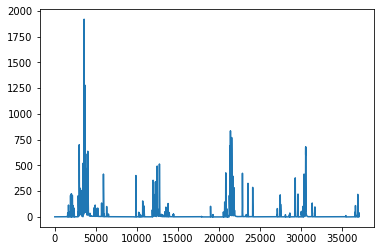

In [25]:
plt.figure()
plt.plot(y_test)
plt.show()

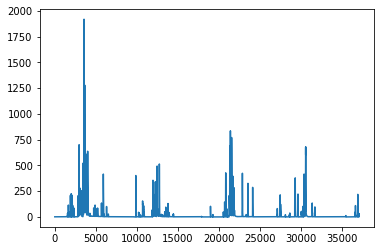

In [26]:
plt.figure()
plt.plot(Y_test_actual)
plt.show()

In [27]:
history = model.fit(X_Train, Y_Train, epochs=10,
                   validation_data=(X_Test, Y_Test))

Epoch 1/10
4691/4691 [==============================] - 63s 13ms/step - loss: 2.3259e-05 - val_loss: 9.5849e-06
Epoch 2/10
4691/4691 [==============================] - 56s 12ms/step - loss: 2.1518e-05 - val_loss: 1.0741e-05
Epoch 3/10
4691/4691 [==============================] - 54s 11ms/step - loss: 1.9014e-05 - val_loss: 1.2183e-05
Epoch 4/10
4691/4691 [==============================] - 80s 17ms/step - loss: 1.9219e-05 - val_loss: 9.5512e-06
Epoch 5/10
4691/4691 [==============================] - 83s 18ms/step - loss: 1.8496e-05 - val_loss: 1.5392e-05
Epoch 6/10
4691/4691 [==============================] - 81s 17ms/step - loss: 1.9159e-05 - val_loss: 1.2318e-05
Epoch 7/10
4691/4691 [==============================] - 91s 19ms/step - loss: 1.7036e-05 - val_loss: 1.4398e-05
Epoch 8/10
4691/4691 [==============================] - 57s 12ms/step - loss: 1.7987e-05 - val_loss: 1.8423e-05
Epoch 9/10
4691/4691 [==============================] - 57s 12ms/step - loss: 1.7473e-05 - val_loss: 1.1

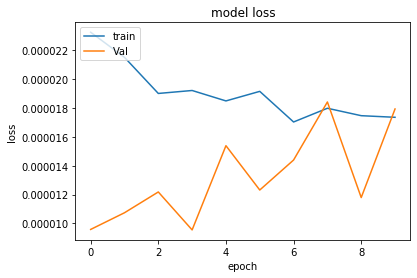

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Val'], loc='upper left')
plt.show()

In [29]:
#model.save("model12_waterflow.hdf5")

In [30]:
predicted_y_values = model.predict(X_Test)

In [31]:
predicted_y_values_unnor = ytest_min_max_scaler.inverse_transform(predicted_y_values)

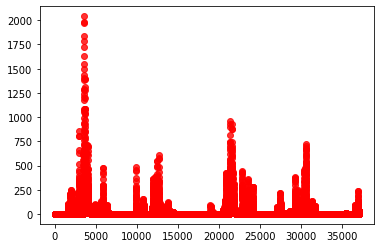

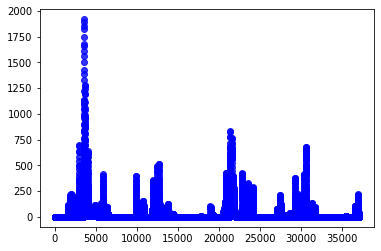

In [32]:
plt.figure()
plt.plot(predicted_y_values_unnor, 'ro', alpha=0.8)
plt.show()
plt.figure()
plt.plot(Y_test_actual, 'bo', alpha=0.8)
plt.show()

In [33]:
mean_square_root = mean_squared_error(predicted_y_values_unnor, Y_test_actual)
mean_square_root

66.12441154754728

In [34]:
# checking mse for test set that are greater than threshold
threshold = 250
timesteps = 18
test_values_above_thres = []
test_labels_above_theres = []

for i in range(timesteps, x_test.shape[0]):
    if (y_test[i] > threshold):
        test_values_above_thres.append(x_test[i-timesteps:i])
        test_labels_above_theres.append(y_test[i]) 
        
X_test_abv_thres = np.array(test_values_above_thres)
Y_test_abv_thres = np.array(test_labels_above_theres)

tsamples, ta, tb = X_test_abv_thres.shape
x_test_for_normalization = X_test_abv_thres.reshape((tsamples,ta*tb)) # since normalization requires 2d array
x_test_for_normalization.shape

X_Test_abv_thres = xtest_min_max_scaler.fit_transform(x_test_for_normalization)
Y_Test_abv_thres = ytest_min_max_scaler.fit_transform(Y_test_abv_thres)

X_Test_abv_thres = X_Test_abv_thres.reshape((tsamples, ta, tb))

In [35]:
predicted_y_test_abv_thres = model.predict(X_Test_abv_thres)
predicted_y_test_abv_thres_unnor = ytest_min_max_scaler.inverse_transform(predicted_y_test_abv_thres)
mean_square_root_abv_thres = mean_squared_error(predicted_y_test_abv_thres, Y_test_abv_thres)
mean_square_root_abv_thres

299536.042791832